In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc, cm
from matplotlib.ticker import FixedLocator
import os.path as osp
import os
import cartopy.crs as ccrs
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point, LineString, Polygon
from shapely import geometry
from cartopy.feature import ShapelyFeature
import networkx as nx
import itertools as it
from PIL import ImageColor
import xarray as xr
from shapely.ops import cascaded_union

In [11]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 12})

dpi = 100

xspacing = FixedLocator([0, 5, 10, 15, 20])
yspacing = FixedLocator([45, 50, 55])

c_radar_loc = '#cc3300'
c_radar_area = '#347B98'
c_boundary = '#092834'
c_boundary_rgb = (9/255, 40/255, 52/255, 0.2)
c_boundary_light = '#0a3142'
c_text = '#262626'
c_countries = 'lightgray'

In [3]:
root = '/home/fiona/birdMigration'
# root = '/media/fiona/Seagate Basic/PhD/paper_1/'
target_dir = osp.join(root, 'data/plots/final')
os.makedirs(target_dir, exist_ok=True)

voronoi = gpd.read_file(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp'))
voronoi = voronoi.to_crs(epsg=4326)

voronoi_b = gpd.read_file(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp'))
voronoi_b = voronoi_b.to_crs(epsg=4326)

delaunay_b = nx.read_gpickle(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'))

radar_buffers = gpd.read_file(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/radar_buffers.shp'))
radars = radar_buffers.centroid.to_crs(epsg=4326)

radar_buffers_b = gpd.read_file(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/radar_buffers.shp'))
radars_b = radar_buffers_b.centroid.to_crs(epsg=4326)

countries = gpd.read_file(osp.join(root, 'data/shapes/ne_10m_admin_0_countries_lakes.shp'))

extent = voronoi_b.total_bounds
extent[1] -= 0.5
crs = ccrs.AlbersEqualArea(central_longitude=voronoi.lon.mean(), central_latitude=voronoi.lat.mean())

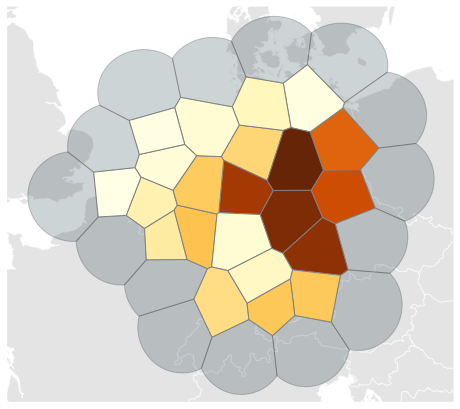

In [421]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white', alpha=0.6)
ax.add_feature(f, facecolor=c_countries, zorder=0)

cmap = cm.get_cmap('YlOrBr')
# r_high = ['defbg', 'demem']
# r_high = ['defbg', 'deisn', 'demem', 'deeis', 'deoft', 'deneu', 'detur']
# r_high = ['defld', 'deneu', 'dedrs', 'deeis', 'deoft', 'detur']
r_high = ['defld', 'deneu', 'dedrs', 'deeis', 'deumd', 'depro']
voronoi_b['rand'] = [np.random.rand() + 1.5 if row.radar in r_high else np.random.rand() for i, row in voronoi_b.iterrows()]
#voronoi_b.loc[voronoi_b.radar.isin(['defld', 'deneu', 'dedrs'])]['rand'] = voronoi_b[voronoi_b.radar.isin(['defld', 'deneu', 'dedrs'])]['rand'].apply(lambda x: x+100)

gplt.polyplot(voronoi_b.query('boundary == 1'), ax=ax, facecolor=c_boundary, alpha=0.2, extent=extent, zorder=2)
gplt.choropleth(voronoi_b.query('boundary == 0'), ax=ax, hue='rand', cmap = cmap, edgecolor='gray', 
                alpha=1, extent=extent, zorder=2)

#gplt.pointplot(radars, ax=ax, extent=extent, zorder=3, color=c_radar_loc, s=4)

fig.savefig(osp.join(target_dir, f'bird_densities_1.png'), bbox_inches='tight', dpi=dpi, transparent=False)

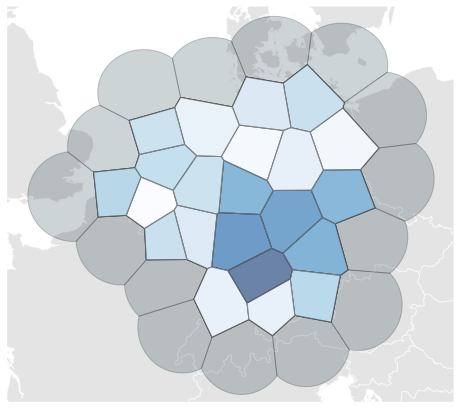

In [426]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

# G = delaunay_b.to_undirected()
# boundary_edges = [(u[0], v[0]) for u, v in it.combinations(list(G.nodes(data=True)), 2) if u[1]['boundary'] and v[1]['boundary']]
# G.remove_edges_from(boundary_edges)

# coord_df = gpd.GeoDataFrame(dict(radar = voronoi_b.radar, 
#                              geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi_b.iterrows()]), 
#                             crs='epsg:4326').to_crs(crs.proj4_init)
# pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
#        (ridx, name) in nx.get_node_attributes(delaunay_b, 'radar').items()}

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0, alpha=0.6)

cmap = cm.get_cmap('Blues')
r_high = ['defld', 'deneu', 'dedrs', 'deeis', 'deoft', 'detur']
# r_high = ['defld', 'deneu', 'dedrs', 'deeis', 'deumd']
voronoi_b['rand'] = [np.random.rand() + 1.2 if row.radar in r_high else np.random.rand() for i, row in voronoi_b.iterrows()]
#voronoi_b.loc[voronoi_b.radar.isin(['defld', 'deneu', 'dedrs'])]['rand'] = voronoi_b[voronoi_b.radar.isin(['defld', 'deneu', 'dedrs'])]['rand'].apply(lambda x: x+100)
#voronoi_b['rand'] = [np.random.rand() for i, row in voronoi_b.iterrows()]

gplt.polyplot(voronoi_b.query('boundary == 1'), ax=ax, facecolor=c_boundary, alpha=0.2, extent=extent, zorder=2)
gplt.polyplot(voronoi_b.query('boundary == 0'), ax=ax, facecolor='white', extent=extent, zorder=2)
gplt.choropleth(voronoi_b.query('boundary == 0'), ax=ax, hue='rand', cmap = cmap, edgecolor='gray', 
                alpha=0.6, extent=extent, zorder=3)

#gplt.pointplot(radars, ax=ax, extent=extent, zorder=3, color=c_radar_loc, s=4)

fig.savefig(osp.join(target_dir, f'takeoff_landing_2.png'), bbox_inches='tight', dpi=dpi, transparent=False)

In [6]:
# prepare graph
G = delaunay_b.copy()
boundary_edges = [(u[0], v[0]) for u, v in it.permutations(list(G.nodes(data=True)), 2) if u[1]['boundary'] and v[1]['boundary']]
G.remove_edges_from(boundary_edges)

# r_high = ['defbg', 'deisn', 'demem', 'deeis', 'deoft', 'deneu', 'detur']
r_high = ['defld', 'deneu', 'dedrs', 'deeis', 'deoft', 'detur']
# r_high = ['defld', 'deneu', 'dedrs', 'deeis', 'deumd']

def reverse(radar1, radar2):
    x1 = voronoi_b.query(f'radar == "{radar1}"').x.values[0]
    x2 = voronoi_b.query(f'radar == "{radar2}"').x.values[0]
    y1 = voronoi_b.query(f'radar == "{radar1}"').y.values[0]
    y2 = voronoi_b.query(f'radar == "{radar2}"').y.values[0]
    
    if x1 > x2: # and y1 > y2:
        return False
    else:
        return True

reverse_edges = [(u[0], v[0]) for u, v in it.permutations(list(G.nodes(data=True)), 2) if reverse(u[1]['radar'], v[1]['radar'])]
G.remove_edges_from(reverse_edges)

coord_df = gpd.GeoDataFrame(dict(radar = voronoi_b.radar, 
                             geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi_b.iterrows()]), 
                            crs='epsg:4326').to_crs(crs.proj4_init)
pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
       (ridx, name) in nx.get_node_attributes(delaunay_b, 'radar').items()}

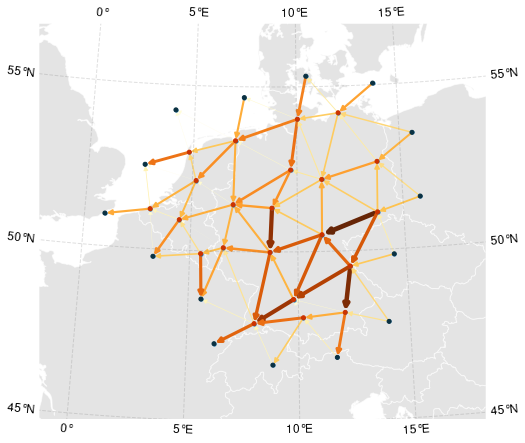

In [9]:
def flux(ridx1, ridx2):
    radar1 = G.nodes(data=True)[ridx1]['radar']
    radar2 = G.nodes(data=True)[ridx2]['radar']
    
    x1 = voronoi_b.query(f'radar == "{radar1}"').x.values[0]
    x2 = voronoi_b.query(f'radar == "{radar2}"').x.values[0]
    y1 = voronoi_b.query(f'radar == "{radar1}"').y.values[0]
    y2 = voronoi_b.query(f'radar == "{radar2}"').y.values[0]
    
    flux = np.random.rand()
    if x1 > x2 and y1 > y2:
        flux += 1
    if radar1 in r_high:
        flux += 1
        
    return flux

fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0, alpha=0.6)

cmap = cm.get_cmap('YlOrBr')

fluxes = np.array([flux(u, v) for u, v in G.edges()])
edge_colors = fluxes / fluxes.max()
edge_colors = cmap(edge_colors)

nx.draw(G, pos=pos, with_labels=False, node_size=10, ax=ax, zorder=4, width = fluxes * 1.6,
            options={'arrowsize': fluxes * 100}, edge_color=edge_colors) #, connectionstyle="arc3,rad=0.1")


# gplt.polyplot(voronoi_b.query('boundary == 1'), ax=ax, facecolor=c_boundary, alpha=0.2, extent=extent, zorder=2)
# gplt.polyplot(voronoi_b.query('boundary == 0'), ax=ax, edgecolor=c_boundary_light, alpha=0.2, extent=extent, zorder=2)

gplt.pointplot(radars, ax=ax, extent=extent, zorder=3, color=c_radar_loc, s=4)
gplt.pointplot(radars_b[voronoi_b.query('boundary == 1').index], ax=ax, extent=extent, zorder=3, color=c_boundary_light, s=4)

#gplt.pointplot(radars, ax=ax, extent=extent, zorder=3, color=c_radar_loc, s=4)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')
gl.xlocator = xspacing
gl.ylocator = yspacing

fig.savefig(osp.join(target_dir, f'fluxes_1_with_grid.png'), bbox_inches='tight', dpi=dpi, transparent=False)

In [115]:
import pandas as pd
df = pd.read_csv('/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=15/radar/fall/2015/dynamic_features.csv')
df.loc[(df['birds'] == 0) & (df.night == 1)]

,Unnamed: 0,radar,solarpos_dt,solarpos,night,dusk,dawn,datetime,dayofyear,tidx,...,sp,t2m,sshf,wind_speed,wind_dir,nightID,acc_rain,acc_wind,wind_profit,missing
153,153,deemd,4.701116,-12.550748,True,False,False,2015-08-07 21:00:00+00:00,219,153,...,101727.462009,292.284864,-2.273765e+06,6.824258,27.618541,7.0,0.000000e+00,0.998628,-6.667786,False
224,224,deemd,6.390838,-6.993305,True,False,False,2015-08-10 20:00:00+00:00,222,224,...,101566.393027,291.365425,-6.576042e+05,3.269581,35.135147,10.0,0.000000e+00,0.999949,-3.245392,False
249,249,deemd,4.735705,-13.671417,True,False,False,2015-08-11 21:00:00+00:00,223,249,...,102042.034166,291.091842,-1.761988e+06,2.687586,113.950984,11.0,0.000000e+00,0.999983,-1.125361,False
250,250,deemd,2.654762,-18.407122,True,False,False,2015-08-11 22:00:00+00:00,223,250,...,102066.779044,290.696751,-1.708112e+06,1.690573,103.086580,11.0,0.000000e+00,0.999983,-0.926399,False
325,325,deemd,-4.314041,-20.127589,True,False,False,2015-08-15 01:00:00+00:00,227,325,...,100478.697769,291.657441,1.397989e+04,5.757952,2.236647,14.0,0.000000e+00,0.777777,-4.787541,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55978,55978,deumd,-7.510240,-48.815707,True,False,False,2015-11-15 01:00:00+00:00,319,2533,...,99788.827354,280.323957,8.842684e+04,17.473777,87.128833,106.0,9.870316e-19,1.000000,-15.392464,False
55979,55979,deumd,-8.652983,-41.305467,True,False,False,2015-11-15 02:00:00+00:00,319,2534,...,99647.060757,280.455868,1.898739e+05,18.217317,87.142090,106.0,9.870316e-19,1.000000,-16.100232,False
55980,55980,deumd,-9.122672,-32.652484,True,False,False,2015-11-15 03:00:00+00:00,319,2535,...,99475.008544,280.547873,3.076072e+05,20.800259,89.042016,106.0,9.870316e-19,1.000000,-18.383633,False
55981,55981,deumd,-9.129441,-23.529812,True,False,False,2015-11-15 04:00:00+00:00,319,2536,...,99303.512602,280.779319,4.268486e+05,24.212997,94.124291,106.0,9.870316e-19,1.000000,-21.090698,False


In [121]:
df['birds'] = df.apply(lambda row: np.nan if (row.night and not row.birds) 
                       else (0 if not row.night else row.birds), axis=1)
#df.loc[(df['birds'] == 0) & (df.night == 1)]['birds'] = np.nan

In [118]:
df['missing'] = 0
for col in ['birds', 'birds_km2']:
    df.missing = df.missing | df[col].isna()

In [119]:
df.query('missing == 1 & radar == "deemd"')[['birds', 'birds_km2']]

,birds,birds_km2
153,NaN,0.0
224,NaN,0.0
249,NaN,0.0
250,NaN,0.0
325,NaN,0.0
...,...,...
2534,NaN,0.0
2535,NaN,0.0
2536,NaN,0.0
2537,NaN,0.0


In [82]:
rd = xr.open_dataset('/home/fiona/birdMigration/data/raw/radar/fall/2015/vpi_nldhl.nc')
rd

<xarray.Dataset>
Dimensions:   (lat: 1, lon: 1, time: 34717)
Coordinates:
  * lat       (lat) float64 52.95
  * lon       (lon) float64 4.8
  * time      (time) datetime64[ns] 2015-08-01T00:00:12 ... 2015-11-30T23:55:11
Data variables:
    solarpos  (time, lon, lat) float32 ...
    mtr       (time, lon, lat) float32 ...
    vid       (time, lon, lat) float32 ...
    vir       (time, lon, lat) float32 ...
    rtr       (time, lon, lat) float32 ...
    mt        (time, lon, lat) float32 ...
    rt        (time, lon, lat) float32 ...
    ff        (time, lon, lat) float32 ...
    dd        (time, lon, lat) float32 ...
    u         (time, lon, lat) float32 ...
    v         (time, lon, lat) float32 ...
    height    (time, lon, lat) float32 ...

In [83]:
rd.sel(time=slice('2015-08-15', '2015-08-16')).vid.values.flatten() #.plot()

array([0.8011613 , 0.44157776, 0.58489174, 0.47536367, 0.59711117,
       0.3902617 , 0.5538306 , 0.38765275, 0.51894355, 0.46779406,
       0.43942118, 0.4534197 , 0.7083149 , 1.0616139 , 1.1435258 ,
       1.0089505 , 0.9124611 , 0.91169566, 1.0828302 , 1.1488613 ,
       1.013512  , 1.421936  , 1.433244  , 1.4509518 , 1.3120806 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.4286378 , 0.782946  , 1.5193777 , 1.3525205 , 1.6106375 ,
       1.376876  , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.511719  ,
       1.7989078 , 1.8797996 , 2.2834718 , 2.537971  , 2.4127374 ,
       3.3998501 , 1.9528502 , 1.9872977 , 2.0325618 , 1.6186241 ,
       1.5138447 , 1.5824106 , 1.4001211 , 1.3395827 , 1.5430304 ,
       1.345202  , 1.5010848 , 0.93114656, 1.0294725 , 1.06056

In [56]:
r = ['a', 'b', 'c']
d = {('a', 'b'):'a', ('x', 'y'):'y'}
check = [rad in r for rad in d.keys()]
check.append(True)
check

[False, False, True]

/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/common.py:1045: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset
/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)


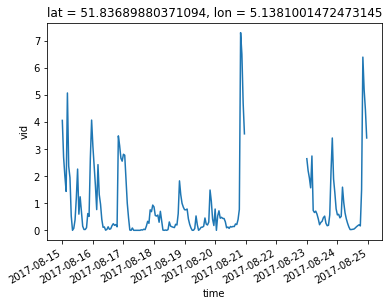

In [46]:
res_rd = rd.resample(time='1H', base=0, skipna=True).reduce(np.nanmean)
res_rd.sel(time=slice('2017-08-15', '2017-08-24')).vid.plot()

In [33]:
sub_rd = rd.sel(time=slice('2015-08-22', '2015-08-24'))
sub_rd = sub_rd.isel(time=(list(range(20))+list(range(50,80))+list(range(130,170))))
sub_rd.time.values

array(['2015-08-22T00:00:00.000000000', '2015-08-22T00:05:00.000000000',
       '2015-08-22T00:10:00.000000000', '2015-08-22T00:15:00.000000000',
       '2015-08-22T00:20:00.000000000', '2015-08-22T00:25:00.000000000',
       '2015-08-22T00:30:00.000000000', '2015-08-22T00:35:00.000000000',
       '2015-08-22T00:40:00.000000000', '2015-08-22T00:45:00.000000000',
       '2015-08-22T00:50:00.000000000', '2015-08-22T00:55:00.000000000',
       '2015-08-22T01:00:00.000000000', '2015-08-22T01:05:00.000000000',
       '2015-08-22T01:10:00.000000000', '2015-08-22T01:15:00.000000000',
       '2015-08-22T01:20:00.000000000', '2015-08-22T01:25:00.000000000',
       '2015-08-22T01:30:00.000000000', '2015-08-22T01:35:00.000000000',
       '2015-08-22T04:10:00.000000000', '2015-08-22T04:15:00.000000000',
       '2015-08-22T04:20:00.000000000', '2015-08-22T04:25:00.000000000',
       '2015-08-22T04:30:00.000000000', '2015-08-22T04:35:00.000000000',
       '2015-08-22T04:40:00.000000000', '2015-08-22

array([ 9.251461 ,  8.398751 ,  8.861519 ,  8.109192 ,  8.456337 ,
        8.163086 ,  8.146125 ,  8.038435 ,  7.7874465,  7.938738 ,
        7.646329 ,  7.553636 ,  7.6135335,  7.333406 ,  8.156798 ,
        7.203098 ,  6.515467 ,  7.33368  ,  7.430361 ,  7.313441 ,
        0.560998 ,  8.215475 , 11.036582 , 11.756255 , 12.773754 ,
       12.092682 , 12.092682 ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.    

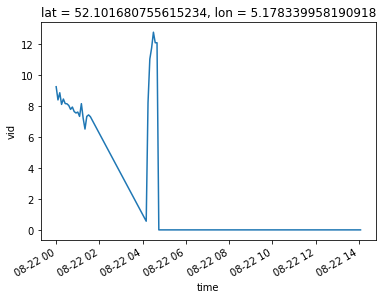

In [36]:
sub_rd.vid.plot()
sub_rd.vid.values.flatten()

/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/common.py:1045: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset
/home/fiona/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1535: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)


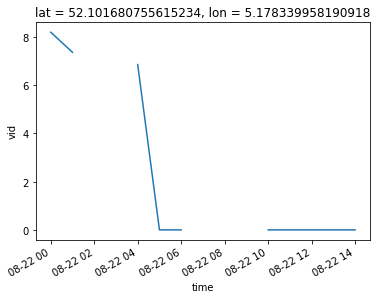

In [40]:
res_rd = sub_rd.resample(time='1H', base=0, skipna=True).reduce(np.nanmean)
res_rd.vid.plot()

In [39]:
res_rd.vid.values.flatten()

array([8.195921, 7.362473,      nan,      nan, 6.852843, 0.      ,
       0.      ,      nan,      nan,      nan, 0.      , 0.      ,
       0.      , 0.      , 0.      ], dtype=float32)

In [21]:
ds = xr.open_dataset(osp.join(root, 'data/raw/env/fall/2015/surface.nc'))
ds

<xarray.Dataset>
Dimensions:    (latitude: 35, longitude: 61, time: 2928)
Coordinates:
  * longitude  (longitude) float32 0.916 1.1660167 ... 15.666984 15.917
  * latitude   (latitude) float32 55.274 55.024 54.774 ... 47.274 47.024 46.774
  * time       (time) datetime64[ns] 2015-08-01 ... 2015-11-30T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    sshf       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-19 10:52:58 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [80]:
ds = xr.open_dataset(osp.join(root, 'data/raw/env/fall/2015/buffer_4_4/pressure_level_850.nc'))
ds_coarse = ds.isel(latitude=slice(0, 66))
ds_coarse = ds_coarse.coarsen(longitude=3).mean().coarsen(latitude=3).mean()

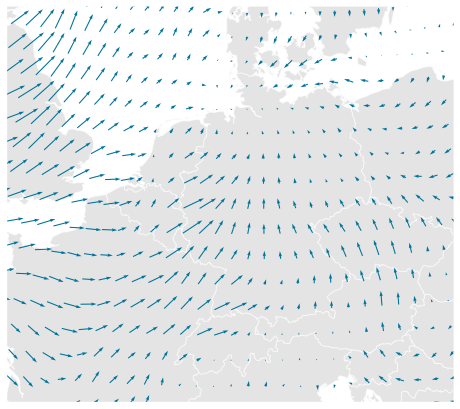

In [171]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

tidx = 80

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0, alpha=0.6)

# b = 500
# outside = gpd.GeoSeries([Polygon([
#     Point(voronoi_b.total_bounds[0]-b, voronoi_b.total_bounds[1]-b),
#     Point(voronoi_b.total_bounds[0]-b, voronoi_b.total_bounds[3]+b),
#     Point(voronoi_b.total_bounds[2]+b, voronoi_b.total_bounds[3]+b),
#     Point(voronoi_b.total_bounds[2]+b, voronoi_b.total_bounds[1]-b)])], crs='EPSG:4326')
# outside = outside.difference(cascaded_union(voronoi_b.geometry))

ax.quiver(ds_coarse.longitude.values, ds_coarse.latitude.values, 
          ds_coarse.u.isel(time=tidx).values, ds_coarse.v.isel(time=0).values, 
          transform=ccrs.PlateCarree(), color='#007399', zorder=1)

gplt.polyplot(voronoi_b.query('boundary == 1'), ax=ax, alpha=0, extent=extent, zorder=2)
# gplt.polyplot(voronoi_b.query('boundary == 0'), ax=ax, alpha=0.2, extent=extent, zorder=2)
# gplt.polyplot(outside, ax=ax, facecolor='white', alpha=1, extent=extent, zorder=3)

fig.savefig(osp.join(target_dir, f'wind_1.png'), bbox_inches='tight', dpi=dpi, transparent=False)

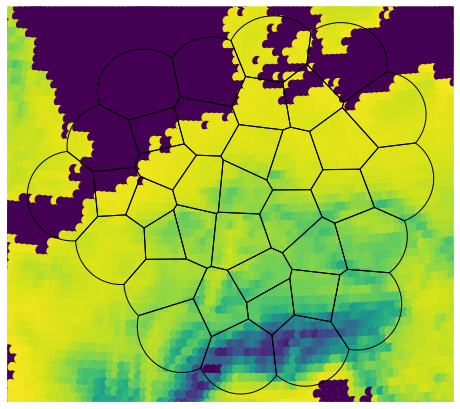

In [20]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

tidx = 80
f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0, alpha=0.6)

# b = 500
# outside = gpd.GeoSeries([Polygon([
#     Point(voronoi_b.total_bounds[0]-b, voronoi_b.total_bounds[1]-b),
#     Point(voronoi_b.total_bounds[0]-b, voronoi_b.total_bounds[3]+b),
#     Point(voronoi_b.total_bounds[2]+b, voronoi_b.total_bounds[3]+b),
#     Point(voronoi_b.total_bounds[2]+b, voronoi_b.total_bounds[1]-b)])], crs='EPSG:4326')
# outside = outside.difference(cascaded_union(voronoi_b.geometry))

var = 'sp'
ds = xr.open_dataset(osp.join(root, 'data/raw/env/fall/2015/buffer_4_4/surface.nc'))
#ds = ds.interpolate_na(dim='time', method="nearest")
df = ds.isel(time=tidx).to_dataframe().reset_index()
gdf = gpd.GeoDataFrame(
    df[var], geometry=gpd.points_from_xy(df.longitude,df.latitude))
gplt.pointplot(gdf, extent=extent, hue=var, ax=ax, s=9, alpha=1)

gplt.polyplot(voronoi_b.query('boundary == 1'), edgecolor='white', ax=ax, alpha=0, extent=extent, zorder=2)
# gplt.polyplot(voronoi_b.query('boundary == 0'), edgecolor='white', ax=ax, alpha=0.2, extent=extent, zorder=2)
# gplt.polyplot(outside, ax=ax, facecolor='white', alpha=1, extent=extent, zorder=3)

gplt.polyplot(voronoi_b, ax=ax, extent=extent, zorder=2)
#fig.savefig(osp.join(target_dir, f'temp_1.png'), bbox_inches='tight', dpi=dpi, transparent=False)

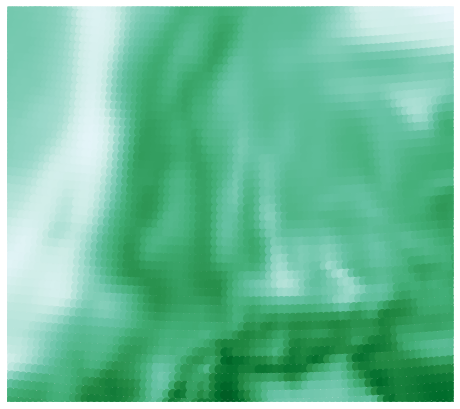

In [186]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

tidx = 80
f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0, alpha=0.6)

# b = 500
# outside = gpd.GeoSeries([Polygon([
#     Point(voronoi_b.total_bounds[0]-b, voronoi_b.total_bounds[1]-b),
#     Point(voronoi_b.total_bounds[0]-b, voronoi_b.total_bounds[3]+b),
#     Point(voronoi_b.total_bounds[2]+b, voronoi_b.total_bounds[3]+b),
#     Point(voronoi_b.total_bounds[2]+b, voronoi_b.total_bounds[1]-b)])], crs='EPSG:4326')
# outside = outside.difference(cascaded_union(voronoi_b.geometry))

df = ds.isel(time=tidx).to_dataframe().reset_index()
gdf = gpd.GeoDataFrame(
    df.q, geometry=gpd.points_from_xy(df.longitude,df.latitude))
gplt.pointplot(gdf, extent=extent, hue='q', ax=ax, s=9, alpha=1, cmap=cm.BuGn)

gplt.polyplot(voronoi_b.query('boundary == 1'), edgecolor='white', ax=ax, alpha=0, extent=extent, zorder=2)
# gplt.polyplot(voronoi_b.query('boundary == 0'), edgecolor='white', ax=ax, alpha=0.2, extent=extent, zorder=2)
# gplt.polyplot(outside, ax=ax, facecolor='white', alpha=1, extent=extent, zorder=3)

fig.savefig(osp.join(target_dir, f'humidity_1.png'), bbox_inches='tight', dpi=dpi, transparent=False)